In [340]:
import mesa
from functional import seq
import random

from dataclasses import dataclass

In [341]:
from typing import Tuple, Optional, List

In [342]:
import matplotlib.pyplot as plt
import numpy as np

# Locations

In [343]:
@dataclass
class Hotel():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    new_rev: int = 0
    total_rev: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

In [344]:
@dataclass
class PointOfInterest():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    visit: int = 0
    total_visit: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

# Tourist

In [353]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.poi :Optional[PointOfInterest] = None

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -=1
        if self.hotel is None and self.remaining_life >= 3:
            hotels = (
                seq(self.model.hotels)
                    .filter(lambda h: h.remaining_capacity() >= 0)
                    .list()
            )

            if len(hotels) <= 0:
                self.remaining_life = -1
                return;

            random.shuffle(hotels)

            self.hotel = hotels[0]
            self.hotel.occupied += 1
            self.hotel.new_rev += 1
            self.hotel.total_rev += 1

            return

        if self.poi is None:
            print("Looking for point of interest")
            no_capacity_poi=[p for p in self.model.pois if p.remaining_capacity()==0]
    
    
            if len(no_capacity_poi) > 0:
                print("NO Point of Interest")
                self.satisfaction -= 1
                print(f"self satisfaction: {self.satisfaction}")
                return self.satisfaction
            elif len(no_capacity_poi)<=0:
                self.satisfaction +=1
                print (f"self satisfaction: {self.satisfaction}")
                return self.satisfaction
            
            random.shuffle(self.model.poi)
            self.poi = self.model.poi[0]
            return


In [354]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [355]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model) -> Tourist:
        # Generate a random trip length based on a normal distribution
        trip_length = max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length)))
        return Tourist(id, model, 0, trip_length)

In [356]:
@dataclass
class SeasonalTouristInflow:
    inflows: List[RandomTouristInflow]
    season_lengths: List[int]

    counter: int = 0

    def new_pops(self) -> int:
        self.counter= (self.counter+1)%sum(self.season_lengths)

        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )


        return self.inflows[current_season].new_pops()

    def new_tourist(self, id: int, model) -> Tourist:
        
        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )

        return self.inflows[current_season].new_tourist(id, model)


# Model

In [357]:
class Model(mesa.Model):
    def __init__(self, num_tourists, num_hotels, num_of_poi, inflow_model):
        self.hotels: List[Hotel] = []
        self.pois: List[PointOfInterest] = []
        self.tourists: List[Tourist] = []

        self.schedule=mesa.time.RandomActivation(self)

        self.inflow = inflow_model

        # Stats
        self.hotel_stats = []
        
        # should be replaced with data from file
        for i in range (num_of_poi):
            self.hotels.append(Hotel(i, 200, 100))

        for i in range (num_hotels):
            self.pois.append(PointOfInterest(i, 200, 100))
            # self.schedule.add(hotel)

        for i in range(num_tourists):
            tourist = Tourist(i, self, 0, 10)
            self.tourists.append(tourist)
            self.schedule.add(tourist)

    def step(self):
        self.update_tourists()
        self.update_tourists()
        self.update_tourists()

        self.remove_tourists()

        self.hotel_stats.append(self.get_hotel_stats())
        print("stats")
        print(self.hotel_stats[-1])

    def update_tourists(self):
        random.shuffle(self.tourists)

        for tourist in self.tourists:
            tourist.step()
        
        for i in range(self.inflow.new_pops()):
            self.tourists.append(self.inflow.new_tourist(i, self))



    def remove_tourists(self):
        remove_index: list[int] = (seq(self.tourists)
            .enumerate()
            .filter(lambda x: x[1].remaining_life < 0)
            .map(lambda x: x[0])
            .sorted(reverse=True)
            .list()
        )
        for i1 in remove_index:
            if self.tourists[i1].hotel:
                self.tourists[i1].hotel.occupied -=1

            del self.tourists[i1]

    def get_hotel_stats(self) -> Tuple[float, float, float, float]:
        total_capacity: int = (seq(self.hotels)
            .map(lambda h: h.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )
        empty_rooms: int = (seq(self.hotels)
            .map(lambda h: h.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )
        occupied_rooms: int = (seq(self.hotels)
            .map(lambda h: h.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        
        new_reservations: int = (seq(self.hotels)
            .map(lambda h: h.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )
        for hotel in self.hotels:
            hotel.new_rev = 0

        return (total_capacity, empty_rooms, occupied_rooms, new_reservations)

    def poi_stats(self) -> Tuple[float]:
        poi_total_capacity: int = (seq(self.pois)
            .map(lambda p: p.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )
        return poi_total_capacity
    
    def plot_hotel_stats(self):
        if not self.hotel_stats:
            print("No stats to plot.")
            return

        stats = np.array(self.hotel_stats)
        time_steps = range(len(stats))

        plt.plot(time_steps, stats[:, 0], label="Total Capacity")
        plt.plot(time_steps, stats[:, 1], label="Empty Rooms")
        plt.plot(time_steps, stats[:, 2], label="Occupied Rooms")
        plt.plot(time_steps, stats[:, 3], label="New Reservations")

        plt.title("Hotel Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Number of Rooms")
        plt.legend()
        plt.grid(True)
        plt.show()

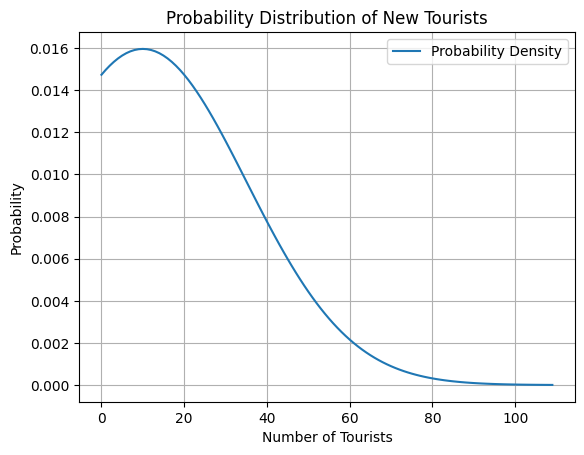

In [358]:

mean_rate=10
stddev_rate=25

x = np.arange(0, mean_rate + 4 * stddev_rate, 1)
y = (1 / (stddev_rate * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_rate) / stddev_rate) ** 2)
plt.plot(x, y, label="Probability Density")
plt.title("Probability Distribution of New Tourists")
plt.xlabel("Number of Tourists")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [359]:
inflow_season_1 = RandomTouristInflow(mean_rate=15, stddev_rate=25, mean_trip_length=15, stddev_trip_length=25)
inflow_season_2 = RandomTouristInflow(mean_rate=10, stddev_rate=5, mean_trip_length=15, stddev_trip_length=25)

# Define the corresponding season lengths
season_lengths = [30*2, 360-30*2]

# Create a SeasonalTouristInflow instance
seasonal_inflow = SeasonalTouristInflow(
    inflows=[inflow_season_1, inflow_season_2],
    season_lengths=season_lengths
)

In [360]:
starter_model=Model(3, 3, 3, seasonal_inflow)
for i in range(360):
    starter_model.step()

Looking for point of interest


AttributeError: 'Model' object has no attribute 'poi'

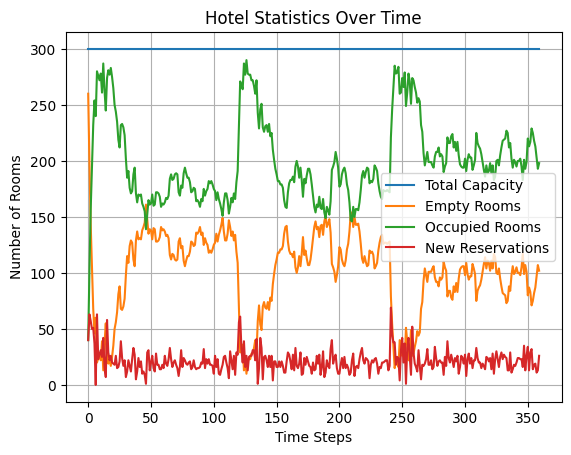

In [339]:
starter_model.plot_hotel_stats()